In [57]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, SkyCoord, ICRS
from astropy.constants import c as c_light_speed
import astropy.units as u
import pystellibs
from numba import njit, prange
from pygaia.errors.astrometric import parallax_uncertainty

In [3]:
sys.path.append('dev/')
from dev.data import PhotData
from dev.star_cluster import StarCluster
from dev.parsec_isochrones import Parsec
from dev.base import PhotometryPipeline
from dev.disk_properties import CondDiskProperties
from dev.yso import YSO
from dev.spectral_interpolator import SpectrumGenerator

parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot'
parsec_file_path = '/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv'
base_path_yso = '/Users/ratzenboe/Documents/work/data_local/spectal_models/yso_models/models_richardson24/'

In [6]:
# Sample random 3D vector
def sample_random_3d_vector():
    vec3d = np.random.uniform(-1, 1, 3)
    vec3d /= np.linalg.norm(vec3d)
    len_vec = np.random.uniform(0, 100)
    vec3d *= len_vec
    return vec3d

def compute_log_luminosity(M, logg, Teff):
    T_sun = 5772
    logg_sun = 4.438
    logM = np.log10(M)
    logTeff = np.log10(Teff / T_sun)
    logL = logM - logg + 4 * logTeff + logg_sun
    return logL

def z_from_feh(feh, z_x_sun=0.0207, y_primordial=0.2485, dY_dZ=1.78):
    """
    Invert [Fe/H] to total metallicity Z.
    """
    z_x = z_x_sun * 10**feh
    numerator = z_x * (1 - y_primordial)
    denominator = 1 + z_x * (1 + dY_dZ)
    Z = numerator / denominator
    return Z

# Load field

In [5]:
fname = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_1kpc_sphere_IRphot_May2024_FINAL.csv'
df_field = pd.read_csv(fname)

# Instantiate cluster pipeline

In [4]:
star_cluster_kwargs = dict(
    mu=np.array([100, 0, 0, 10, 10, 10]),
    cov=np.diag([10, 10, 10, 1, 1, 1]),
    cluster_mass=1e3,
    logAge=6.0,
    Z=0.0125
)

phpipe = PhotometryPipeline(steps=[
    ('cluster', StarCluster(**star_cluster_kwargs)),
    ('parsec_isochrones', Parsec(parsec_folder_path)),
    # ('disk_prop', CondDiskProperties()),
    # ('yso_model', YSO(base_dir=base_path_yso, yso_models='all')),
    # ('spectrum', SpectrumGenerator(stellib=pystellibs.BaSeL())),
])

PARSEC isochrones read and processed!


# Generate clusters

In [109]:
cluster_data = []
mean_parallax_error = 0.4  # mas
C = np.eye(6)
i = 0
while i < 100:
    df_subset = df_field.sample(1)
    x, y, z, A_V_local, feh_local = df_subset[['X', 'Y', 'Z', 'A_V', 'feh']].values[0]
    Z_local = z_from_feh(feh_local)
    # x, y, z = 700, 700, 0
    dist = np.sqrt(x**2 + y**2 + z**2)
    if (abs(z) < 22) and (dist < 950) and (dist > 5):
        print(f'Processing cluster at z={z}')
        feh_cluster = min([feh_local + 0.05, 0.3])
        # TODO: model the cluster dispersion in velocity and position as a function of age
        C_cluster = np.copy(C)
        xyz_disp = np.random.uniform(4, 9)
        C_cluster[:3, :3] *= xyz_disp**2
        vel_disp = np.random.uniform(2, 5)
        C_cluster[3:, 3:] *= vel_disp**2
        # Randomly sample age
        linAge = np.random.exponential(150, 1)[0]
        logAge = np.log10(linAge*1e6)
        if linAge > 1.01:
            # print('logAge:', logAge)
            # Sample cluster mass
            mass = np.random.uniform(1e1, 5e2)*2
            u_vel, v_vel, w_vel = sample_random_3d_vector()
            mu_6d = np.array([x, y, z, u_vel, v_vel, w_vel])
            # print('mu_6d:', mu_6d)
            print(f'Generate cluster with logAge: {logAge}')
            data = PhotData()
            phpipe.set_params(
                cluster__mu=mu_6d,    # <-- update cluster center
                cluster__cov=C_cluster,
                cluster__logAge=logAge,
                cluster__Z=Z_local,
                cluster__cluster_mass=mass,
            )
            data = phpipe.run(data)

            df_cluster = pd.DataFrame(dict(
                mass=data.mass,
                logAge=data.logAge,
                Z_metal=data.Z,
                Av=A_V_local,
                logL=data.logL,
                logg=data.logg,
                logT=data.logT,
                logR=data.logR,
                ra=data.skycoords.ra.value,
                dec=data.skycoords.dec.value,
                distance=data.skycoords.distance.value,
                pmra=data.skycoords.pm_ra.value,
                pmdec=data.skycoords.pm_dec.value,
                radial_velocity=data.skycoords.radial_velocity.value,
            ))
            c_gal = data.skycoords.transform_to(Galactic())
            c_gal.representation_type = 'cartesian'
            df_cluster['X_pc'] = c_gal.u.value
            df_cluster['Y_pc'] = c_gal.v.value
            df_cluster['Z_pc'] = c_gal.w.value
            df_cluster['parallax'] = 1000/df_cluster.distance.values

            # Observed XYZ
            df_cluster['parallax_obs'] = df_cluster['parallax'] + np.random.normal(0, mean_parallax_error, len(df_cluster))
            skycoords = SkyCoord(
                ra=data.skycoords.ra.value * u.deg,
                dec=data.skycoords.dec.value * u.deg,
                distance=1000/df_cluster['parallax_obs']*u.pc,
                frame='icrs',
            )
            c_gal_obs = skycoords.transform_to(Galactic())
            c_gal_obs.representation_type = 'cartesian'
            df_cluster['X_pc_obs'] = c_gal_obs.u.value
            df_cluster['Y_pc_obs'] = c_gal_obs.v.value
            df_cluster['Z_pc_obs'] = c_gal_obs.w.value

            # Label infos
            df_cluster['labels'] = i
            cluster_data.append(df_cluster)
            i += 1

Processing cluster at z=-4.614391532755448
Generate cluster with logAge: 7.935390579157245
Total cluster mass is 101.92 (limit was 110.715)
Processing cluster at z=19.31697964704609
Generate cluster with logAge: 6.499957388391839
Total cluster mass is 456.078 (limit was 458.17)
Processing cluster at z=-1.13119009804158
Generate cluster with logAge: 7.483431197376771
Total cluster mass is 478.878 (limit was 478.524)
Processing cluster at z=-3.938140235149625
Generate cluster with logAge: 8.256112007549813
Total cluster mass is 244.776 (limit was 244.843)
Processing cluster at z=6.124205360933318
Generate cluster with logAge: 7.945514566675343
Total cluster mass is 664.982 (limit was 666.424)
Processing cluster at z=4.4332562659849595
Generate cluster with logAge: 7.9688464013495945
Total cluster mass is 43.2159 (limit was 43.2241)
Processing cluster at z=8.956425874258965
Processing cluster at z=20.573158883616053
Generate cluster with logAge: 8.718393782365078
Total cluster mass is 290

In [110]:
df_clusters_all = pd.concat(cluster_data)

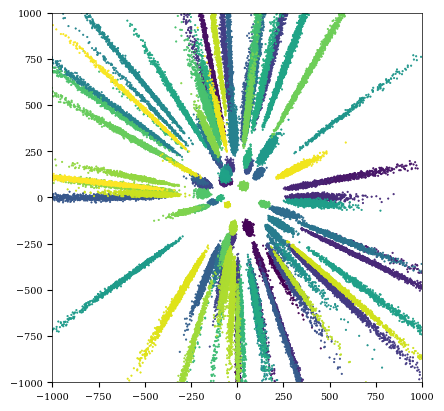

In [112]:
plt.scatter(df_clusters_all['X_pc_obs'], df_clusters_all['Y_pc_obs'], s=1, c=df_clusters_all['labels'])
lim = 1000
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [113]:
df_clusters_all.to_csv('/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_1kpc_fundamentals_June2025.csv')

(array([3300.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  475.,
         710., 2114., 1978., 4017.,    0.,    0., 1343.,  251., 2995.,
        2567.,    0., 2736., 4572.,    0.,    0., 4555., 2321., 2098.,
        1825.,    0., 1319., 7808., 1168.,    0.,  877., 4521., 2797.,
        2745., 1267.,    0.,    0.,    0., 3295., 5831., 2459.,    0.,
        1524., 1115., 3887., 1490.,    0., 3062., 1027.,    0., 2384.,
        2173., 2721., 3306.,    0., 1078., 3027.,    0.,  103.,    0.,
           0.,    0., 1594.,    0.,    0., 1646., 2198., 2916.,  527.,
          46.,    0.,  872.,  328.,    0.,  283.,    0.,    0.,    0.,
           0., 2044.,  436.,    0.,    0.,    0., 2369.,    0., 2058.,
         696.,    0., 1780.,    0.,  367.,    0.,    0., 1944.,    0.,
         479.]),
 array([0.00439035, 0.00461489, 0.00483943, 0.00506397, 0.00528851,
        0.00551306, 0.0057376 , 0.00596214, 0.00618668, 0.00641122,
        0.00663576, 0.0068603 , 0.00708484, 0.00730938, 0.00753393

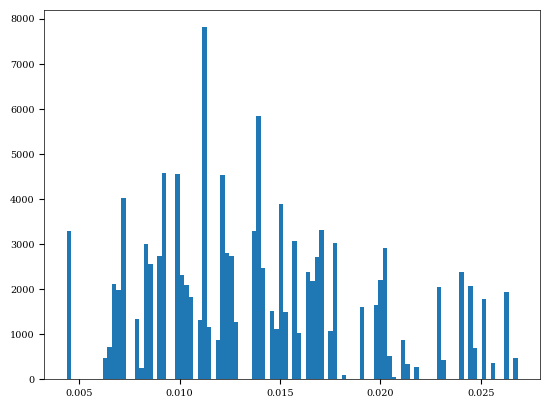